# Describe predictions from the SFG branch of pipeline

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import matplotlib.patches as mpatches
from matplotlib import ticker
from matplotlib.collections import LineCollection
from matplotlib.ticker import AutoMinorLocator, ScalarFormatter, MultipleLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.model_selection import train_test_split
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.cosmology import Planck18 as cosmo
from astropy.stats import sigma_clip
# import pyccl as ccl
from astropy import units as u
from scipy.ndimage import gaussian_filter
import colorcet as cc
import cmasher as cmr
import met_brewer
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()
plt.rcParams['text.usetex'] = True

In [3]:
def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x        = np.asarray(x)
    y        = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid   = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end   = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments    = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [4]:
def create_median_values(x, y, z, nbins=10, scale='log'):
    min_z = np.nanmin(z)
    max_z = np.nanmax(z)
    if scale == 'log':
        z_bins = np.logspace(np.log10(min_z), np.log10(max_z), nbins)
    elif scale == 'linear':
        z_bins = np.linspace(min_z, max_z, nbins)
    elif scale == 'inverselog':
        linear_space = np.linspace(0, 1, nbins)
        power  = 2
        z_bins = min_z + (max_z - min_z) * (linear_space ** power)
    med_x = []
    med_y = []
    med_z = []
    for count, z_bin in enumerate(z_bins[:-1]):
        filter_z = np.array(z >= z_bins[count]) & np.array(z < z_bins[count + 1])
        med_x.append(np.nanmedian(x[filter_z]))
        med_y.append(np.nanmedian(y[filter_z]))
        med_z.append(np.nanmedian(z[filter_z]))
    return med_x, med_y, med_z

In [5]:
colour_hex_SFG = '#1E88E5'
colour_hex_AGN = '#D32F2F'
black_hex      = '#000000'

colour_rSFG = mcolors.to_rgba(colour_hex_SFG)
colour_rAGN = mcolors.to_rgba(colour_hex_AGN)
colour_rSFG_shade = gf.create_shaded_colour(colour_hex_SFG)
colour_rAGN_shade = gf.create_shaded_colour(colour_hex_AGN)
colour_rSFG_rgb_darker, colour_rSFG_rgb_bright = gf.create_darker_brighter_rgb(colour_hex_SFG)
colour_rAGN_rgb_darker, colour_rAGN_rgb_bright = gf.create_darker_brighter_rgb(colour_hex_AGN)

cm_gradient_rAGN = mcolors.LinearSegmentedColormap.from_list('gradient_rAGN',
                                                             [colour_rAGN_rgb_darker,
                                                              colour_rAGN_rgb_bright], N=50)
cm_gradient_rSFG = mcolors.LinearSegmentedColormap.from_list('gradient_rGal',
                                                             [colour_rSFG_rgb_darker,
                                                              colour_rSFG_rgb_bright], N=50)
cm_gradient = {'rAGN': cm_gradient_rAGN, 'rSFG': cm_gradient_rSFG}

cm_gradient_AGN = gf.create_colour_gradient(colour_hex_AGN)
cm_gradient_SFG = gf.create_colour_gradient(colour_hex_SFG)
cm_grad_AGN_whi = gf.create_colour_gradient_to_white(colour_hex_AGN)
cm_grad_SFG_whi = gf.create_colour_gradient_to_white(colour_hex_SFG)

colour_black      = mcolors.to_rgba(black_hex)
cm_gradient_black = gf.create_colour_gradient(black_hex)

In [6]:
colour_ish = met_brewer.met_brew(name='Isfahan2', n=123, brew_type='continuous')
colour_ish_mpl = mcolors.LinearSegmentedColormap.from_list('Isfahan2', colour_ish, N=11)
cmap_hist2d_cats_SFG = colour_ish_mpl

In [7]:
save_plots  = False

In [8]:
used_sample = 'unknown'  # 'test', 'unknown'

In [9]:
file_HETDEX_test = gv.preds_path + 'HETDEX_Test_prediction.parquet'
file_HETDEX_unk  = gv.preds_path + 'HETDEX_Unknown_prediction.parquet'
files_HETDEX     = {'test': file_HETDEX_test, 'unknown': file_HETDEX_unk}

In [10]:
data_catalog_HETDEX_df = pd.read_parquet(files_HETDEX[used_sample], engine='fastparquet')

In [11]:
np.shape(data_catalog_HETDEX_df)

(15018144, 103)

In [12]:
data_catalog_HETDEX_df.columns.values

array(['RA_ICRS', 'DE_ICRS', 'Name', 'TYPE', 'Z', 'band_num',
       'Sint_LOFAR', 'Sint_LOFAR_non_imp', 'rms_LOFAR', 'Speak_LOFAR',
       'Speak_LOFAR_non_imp', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag',
       'imag', 'zmag', 'ymag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag',
       'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2',
       'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1',
       'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1',
       'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2',
       'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3',
       'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K',
       'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4',
       'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4',
       'radio_detect', 'LOFAR_detect', 'class', 'Prob_AGN',
       'pred_class_cal', 'Prob_radio_AGN', 'pred_radio_AGN_cal',
       'Prob_radio_SFG', 'pred_radio_

In [13]:
mask_pred_AGN       = np.array(data_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 1)
mask_pred_SFG       = np.array(data_catalog_HETDEX_df.loc[:, 'pred_class_cal'] == 0)
mask_pred_radio_AGN = np.array(data_catalog_HETDEX_df.loc[:, 'pred_radio_AGN_cal'] == 1)
mask_pred_radio_SFG = np.array(data_catalog_HETDEX_df.loc[:, 'pred_radio_SFG_cal'] == 1)
mask_pred_rAGN      = mask_pred_AGN & mask_pred_radio_AGN
mask_pred_rSFG      = mask_pred_SFG & mask_pred_radio_SFG

if used_sample != 'unknown':
    mask_true_AGN       = np.array(data_catalog_HETDEX_df.loc[:, 'class'] == 1)
    mask_true_SFG       = np.array(data_catalog_HETDEX_df.loc[:, 'class'] == 0)
    mask_true_radio     = np.array(data_catalog_HETDEX_df.loc[:, 'LOFAR_detect'] == 1)
    mask_true_rAGN      = mask_true_AGN & mask_true_radio
    mask_true_rSFG      = mask_true_SFG & mask_true_radio
    mask_good_true_z    = np.array(data_catalog_HETDEX_df.loc[:, 'Z'] > 0)

In [52]:
print(f'Subset has {len(data_catalog_HETDEX_df):,.0f} sources')
print(f'Out of {len(data_catalog_HETDEX_df):,.0f}, {np.sum(mask_pred_SFG):,.0f} sources predicted as SFGs')
print(f'Out of {np.sum(mask_pred_SFG):,.0f}, {np.sum(mask_pred_rSFG):,.0f} sources predicted as radio detectable')

Subset has 15,018,144 sources
Out of 15,018,144, 5,043,014 sources predicted as SFGs
Out of 5,043,014, 154,161 sources predicted as radio detectable


y-j vs H-K, most relevant redshift SHAP drivers for SFGs

In [53]:
data_catalog_HETDEX_df.loc[mask_pred_rSFG, ['Prob_radio_SFG', 'pred_Z_rSFG']].describe()

,Prob_radio_SFG,pred_Z_rSFG
count,154161.000000,154161.000000
mean,0.377054,0.424904
std,0.203180,0.297967
min,0.199572,0.013000
25%,0.236702,0.194200
50%,0.290896,0.348600
75%,0.427285,0.567000
max,0.929218,1.502200


There are 14879352 sources inside contours
There are 138792 sources outside contours
It is expected to have 150181 sources outside contours


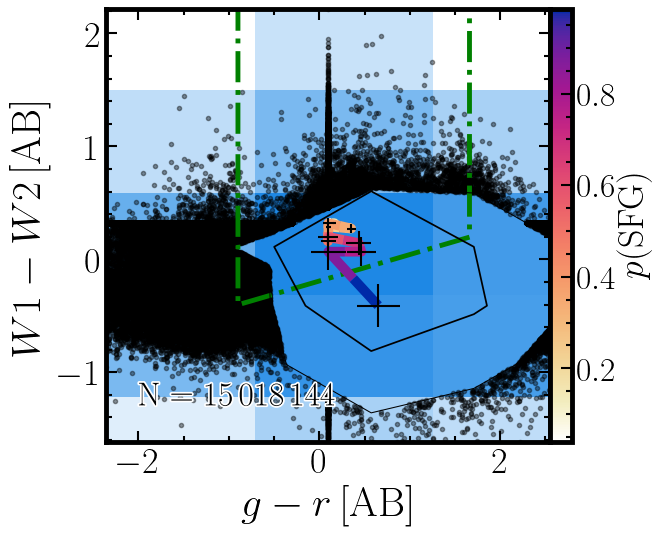

In [43]:
fig                = plt.figure(figsize=(6.5, 5.25), layout='constrained')
ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')

try:
    norm_dens = mcolors.LogNorm()
except:
    pass

column_x         = 'g_r'
column_y         = 'W1_W2'
column_z         = 'Prob_AGN'  # 

xlabel           = r'$g - r\, [\mathrm{AB}]$'
ylabel           = r'$W1 - W2\, [\mathrm{AB}]$'
mask_valid_vals  = np.isfinite(data_catalog_HETDEX_df.loc[:, column_x]) &\
                   np.isfinite(data_catalog_HETDEX_df.loc[:, column_y])
filter_good_cols  = mask_valid_vals

dens_plot_data_x = data_catalog_HETDEX_df.loc[filter_good_cols, column_x]
dens_plot_data_y = data_catalog_HETDEX_df.loc[filter_good_cols, column_y]
dens_plot_data_z = 1 - data_catalog_HETDEX_df.loc[filter_good_cols, column_z]
N_sources        = np.nansum(filter_good_cols)

min_X  = np.nanmin(dens_plot_data_x)
max_X  = np.nanmax(dens_plot_data_x)
min_Y  = np.nanmin(dens_plot_data_y)
max_Y  = np.nanmax(dens_plot_data_y)

min_X_plot  = np.nanmin(sigma_clip(dens_plot_data_x, sigma=5, masked=False))
max_X_plot  = np.nanmax(sigma_clip(dens_plot_data_x, sigma=5, masked=False))
min_Y_plot  = np.nanmin(sigma_clip(dens_plot_data_y, sigma=6, masked=False))
max_Y_plot  = np.nanmax(sigma_clip(dens_plot_data_y, sigma=6, masked=False))
# max_X  = np.nanmax(1 + 1.99)  # Ad-hoc limit
# max_Y  = np.nanmax(1 + 1.99)  # Ad-hoc limit
n_bins = [20, 20]
bins_X_cont = np.linspace(min_X, max_X, int(np.floor(n_bins[0] * 1.7)))
bins_Y_cont = np.linspace(min_Y, max_Y, int(np.floor(n_bins[1] * 1.7)))
bins_X_hist = np.linspace(min_X, max_X, n_bins[0])
bins_Y_hist = np.linspace(min_Y, max_Y, n_bins[1])
bins_arr_cont = [bins_X_cont, bins_Y_cont]
bins_arr_hist = [bins_X_hist, bins_Y_hist]

dens_CW = gf.color_hist2d_scipy(dens_plot_data_x,
                                dens_plot_data_y,
                                dens_plot_data_z,
                                ax_tmp=ax1,
                                target_statistic='count',
                                bins=bins_arr_hist,
                                cmap=cm_grad_SFG_whi,
                                lw=0,
                                norm=norm_dens)

added_lim_up    = 0.0  # 0.049
added_lim_do    = 0.99  # 9.9e-1
# lims_x          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
# lims_y          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
lims_x          = (added_lim_do, max_X)
lims_y          = (added_lim_do, max_Y)

# sigmas_perc     = [0.39346934, 0.86466472, 0.988891]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc     = [0.5, 0.75, 0.95, 0.99]  # [50%, 75%, 95% of data]
outlier_number  = int(np.floor(N_sources * (1 - sigmas_perc[-1]))) # expected number of points outside last contour
nstep           = len(sigmas_perc)
seq_cont        = np.linspace(0, 1, nstep)

H_SFG, xedges_SFG, yedges_SFG = np.histogram2d(dens_plot_data_x, dens_plot_data_y,
                                               bins=bins_arr_cont, density=False)

# cont_SFG = ax1.scatter([-1], [10], marker='o', edgecolor=colour_rSFG, color=colour_black,
#                        s=80, label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)

# Flatten histogram and sort by density
H_flat   = H_SFG.ravel()
H_sorted = np.sort(H_flat)[::-1]  # Sort descending
cumulative_density = np.cumsum(H_sorted) / np.sum(H_sorted)

# Find bin count thresholds for the desired percentiles
target_percentiles = np.array(sigmas_perc) * np.sum(H_SFG)
density_thresholds = []
for target in target_percentiles:
    idx = np.argmin(np.abs(cumulative_density * np.sum(H_SFG) - target))
    threshold = H_sorted[idx]
    density_thresholds.append(threshold)
density_thresholds = sorted(set(density_thresholds), reverse=True)  # Ensure unique, decreasing values

# fix probable lines not closing
H_SFG, x_centers_SFG, y_centers_SFG = gf.pad_matrix_zeros(H_SFG, xedges_SFG, yedges_SFG)

# Plot contours using the computed density thresholds
CS_SFG = ax1.contour(x_centers_SFG, y_centers_SFG, H_SFG.T,  
                     levels=density_thresholds[::-1],  
                     colors=cm_gradient_black.reversed()(seq_cont),  
                     linewidths=np.linspace(0.75, 2.25, len(sigmas_perc)), zorder=3)

# Calculate percentage levels from density thresholds
# density_percentages = [100.0 * cumulative_density[np.searchsorted(np.sort(H_flat), level)] for level in density_thresholds]
density_percentages = [100 * sigma_perc for sigma_perc in sigmas_perc]

# Identify and plot points outside contours
try:
    p_SFG = CS_SFG.get_paths()
except Exception as e:
    p_SFG = CS_SFG.collections[0].get_paths()
inside_SFG = np.full_like(dens_plot_data_x, False, dtype=bool)
for level in p_SFG:
    inside_SFG |= level.contains_points(np.column_stack((dens_plot_data_x, dens_plot_data_y)))
print(f'There are {np.sum(inside_SFG)} sources inside contours')
print(f'There are {np.sum(~inside_SFG)} sources outside contours')
print(f'It is expected to have {outlier_number} sources outside contours')
out_SFG, = ax1.plot(dens_plot_data_x.loc[~inside_SFG], dens_plot_data_y.loc[~inside_SFG],
                    marker='.', ls='None', color=colour_black, zorder=2, alpha=0.4)

num_str = f'$\mathrm{{N}} = {N_sources}$'
if N_sources / 1e4 > 1:
    num_str = f'$\mathrm{{N}} = {N_sources:,.0f}$'.replace(',', '$\,$')
ax1.annotate(num_str, xy=(0.07, 0.07), xycoords='axes fraction',
                    fontsize=24, path_effects=gf.path_white(2.5),
                    va='bottom', ha='left')

norm_z  = mcolors.Normalize()
# lines = colored_line(med_x, med_y, med_z, ax1, linewidth=5, cmap='cet_glasbey_hv', zorder=3)
med_x, med_y, med_z = create_median_values(dens_plot_data_x,
                                           dens_plot_data_y,
                                           dens_plot_data_z,
                                           nbins=12, scale='linear')
lines = colored_line(med_x, med_y, med_z,
                     ax1, linewidth=7, cmap='cet_CET_L17', zorder=3, norm=norm_z)
# ax1.plot(med_x, med_y, marker='+', ls='None', color='k', ms=10, zorder=4)
ax1.scatter(med_x, med_y, marker='+', ls='None', color='k', s=(np.array(med_z)**2 * 100)**1.5, zorder=4)

points_C23 = np.array([[-0.90, -0.90, 1.66, 1.66], [2.3, -0.40246, 0.19682, 2.3]])
C23_plot,  = ax1.plot(points_C23[0], points_C23[1], label=r'$\mathrm{C23}$',
                      c='green', zorder=2, lw=3.5, ls='-.')

# ax1.set_xlim(lims_x)
# ax1.set_ylim(lims_y)

# ax1.set_xlim(left=-0.6, right=1.1)
# ax1.set_ylim(bottom=-0.2, top=5.0)
ax1.set_xlim(left=min_X_plot, right=max_X_plot)
ax1.set_ylim(bottom=min_Y_plot, top=max_Y_plot)

# cbar_str = r'$\mathrm{Sources ~ per ~ bin}$'
# cbar = fig.colorbar(dens_CW[1], ax=ax1, pad=0.0, format=ScalarFormatter())
# cbar.ax.minorticks_on()
# cbar.ax.tick_params(labelsize=24)
# cbar.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
# cbar.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
# cbar.outline.set_linewidth(3.5)
# cbar.ax.set_ylabel(cbar_str, size=26, labelpad=-1)

cbar_z_str = r'$p(\mathrm{SFG})$'
cbar_z = fig.colorbar(lines, ax=ax1, pad=0.0, format=ScalarFormatter())
cbar_z.ax.minorticks_on()
cbar_z.ax.tick_params(labelsize=24)
cbar_z.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
cbar_z.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
cbar_z.outline.set_linewidth(3.5)
cbar_z.ax.set_ylabel(cbar_z_str, size=26, labelpad=-0.5)

ax1.minorticks_on()
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=26)
# ax1.tick_params(axis='both', which='minor', labelsize=26)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(xlabel, size=30)
ax1.set_ylabel(ylabel, size=30)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)

if save_plots:
    plt.savefig(gv.plots_path + f'prob_SFG_evol_W1_W2_g_r_SFG_{used_sample}_HETDEX.pdf',
                bbox_inches='tight')

plt.show()

There are 4991817 sources inside contours
There are 51197 sources outside contours
It is expected to have 50430 sources outside contours


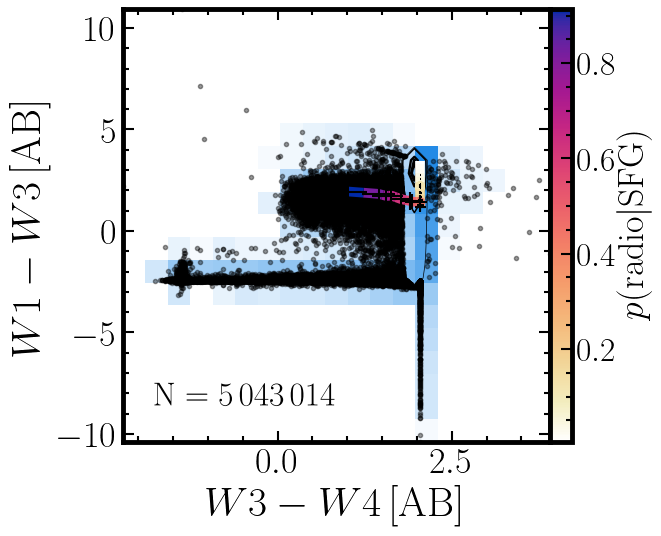

In [39]:
fig                = plt.figure(figsize=(6.5, 5.25), layout='constrained')
ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')

try:
    norm_dens = mcolors.LogNorm()
except:
    pass

column_x         = 'W3_W4'
column_y         = 'W1_W3'
column_z         = 'Prob_radio_SFG'  # 

xlabel           = r'$W3 - W4\, [\mathrm{AB}]$'
ylabel           = r'$W1 - W3\, [\mathrm{AB}]$'
mask_valid_vals  = np.isfinite(data_catalog_HETDEX_df.loc[:, column_x]) &\
                   np.isfinite(data_catalog_HETDEX_df.loc[:, column_y])
filter_good_cols  = mask_valid_vals & mask_pred_SFG

dens_plot_data_x = data_catalog_HETDEX_df.loc[filter_good_cols, column_x]
dens_plot_data_y = data_catalog_HETDEX_df.loc[filter_good_cols, column_y]
dens_plot_data_z = data_catalog_HETDEX_df.loc[filter_good_cols, column_z]
N_sources        = np.nansum(filter_good_cols)

min_X  = np.nanmin(dens_plot_data_x)
max_X  = np.nanmax(dens_plot_data_x)
min_Y  = np.nanmin(dens_plot_data_y)
max_Y  = np.nanmax(dens_plot_data_y)

min_X_plot  = np.nanmin(sigma_clip(dens_plot_data_x, sigma=10, masked=False))
max_X_plot  = np.nanmax(sigma_clip(dens_plot_data_x, sigma=10, masked=False))
min_Y_plot  = np.nanmin(sigma_clip(dens_plot_data_y, sigma=10, masked=False))
max_Y_plot  = np.nanmax(sigma_clip(dens_plot_data_y, sigma=10, masked=False))
# max_X  = np.nanmax(1 + 1.99)  # Ad-hoc limit
# max_Y  = np.nanmax(1 + 1.99)  # Ad-hoc limit
n_bins = [20, 20]
bins_X_cont = np.linspace(min_X, max_X, int(np.floor(n_bins[0] * 1.7)))
bins_Y_cont = np.linspace(min_Y, max_Y, int(np.floor(n_bins[1] * 1.7)))
bins_X_hist = np.linspace(min_X, max_X, n_bins[0])
bins_Y_hist = np.linspace(min_Y, max_Y, n_bins[1])
bins_arr_cont = [bins_X_cont, bins_Y_cont]
bins_arr_hist = [bins_X_hist, bins_Y_hist]

dens_CW = gf.color_hist2d_scipy(dens_plot_data_x,
                                dens_plot_data_y,
                                dens_plot_data_z,
                                ax_tmp=ax1,
                                target_statistic='count',
                                bins=bins_arr_hist,
                                cmap=cm_grad_SFG_whi,
                                lw=0,
                                norm=norm_dens)

added_lim_up    = 0.0  # 0.049
added_lim_do    = 0.99  # 9.9e-1
# lims_x          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
# lims_y          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
lims_x          = (added_lim_do, max_X)
lims_y          = (added_lim_do, max_Y)

# sigmas_perc     = [0.39346934, 0.86466472, 0.988891]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc     = [0.5, 0.75, 0.95, 0.99]  # [50%, 75%, 95% of data]
outlier_number  = int(np.floor(N_sources * (1 - sigmas_perc[-1]))) # expected number of points outside last contour
nstep           = len(sigmas_perc)
seq_cont        = np.linspace(0, 1, nstep)

H_SFG, xedges_SFG, yedges_SFG = np.histogram2d(dens_plot_data_x, dens_plot_data_y,
                                               bins=bins_arr_cont, density=False)

# cont_SFG = ax1.scatter([-1], [10], marker='o', edgecolor=colour_rSFG, color=colour_black,
#                        s=80, label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)

# Flatten histogram and sort by density
H_flat   = H_SFG.ravel()
H_sorted = np.sort(H_flat)[::-1]  # Sort descending
cumulative_density = np.cumsum(H_sorted) / np.sum(H_sorted)

# Find bin count thresholds for the desired percentiles
target_percentiles = np.array(sigmas_perc) * np.sum(H_SFG)
density_thresholds = []
for target in target_percentiles:
    idx = np.argmin(np.abs(cumulative_density * np.sum(H_SFG) - target))
    threshold = H_sorted[idx]
    density_thresholds.append(threshold)
density_thresholds = sorted(set(density_thresholds), reverse=True)  # Ensure unique, decreasing values

# fix probable lines not closing
H_SFG, x_centers_SFG, y_centers_SFG = gf.pad_matrix_zeros(H_SFG, xedges_SFG, yedges_SFG)

# Plot contours using the computed density thresholds
CS_SFG = ax1.contour(x_centers_SFG, y_centers_SFG, H_SFG.T,  
                     levels=density_thresholds[::-1],  
                     colors=cm_gradient_black.reversed()(seq_cont),  
                     linewidths=np.linspace(0.75, 2.25, len(sigmas_perc)), zorder=3)

# Calculate percentage levels from density thresholds
# density_percentages = [100.0 * cumulative_density[np.searchsorted(np.sort(H_flat), level)] for level in density_thresholds]
density_percentages = [100 * sigma_perc for sigma_perc in sigmas_perc]

# Identify and plot points outside contours
try:
    p_SFG = CS_SFG.get_paths()
except Exception as e:
    p_SFG = CS_SFG.collections[0].get_paths()
inside_SFG = np.full_like(dens_plot_data_x, False, dtype=bool)
for level in p_SFG:
    inside_SFG |= level.contains_points(np.column_stack((dens_plot_data_x, dens_plot_data_y)))
print(f'There are {np.sum(inside_SFG)} sources inside contours')
print(f'There are {np.sum(~inside_SFG)} sources outside contours')
print(f'It is expected to have {outlier_number} sources outside contours')
out_SFG, = ax1.plot(dens_plot_data_x.loc[~inside_SFG], dens_plot_data_y.loc[~inside_SFG],
                    marker='.', ls='None', color=colour_black, zorder=2, alpha=0.4)

num_str = f'$\mathrm{{N}} = {N_sources}$'
if N_sources / 1e4 > 1:
    num_str = f'$\mathrm{{N}} = {N_sources:,.0f}$'.replace(',', '$\,$')
ax1.annotate(num_str, xy=(0.07, 0.07), xycoords='axes fraction',
                    fontsize=24, path_effects=gf.path_white(2.5),
                    va='bottom', ha='left')

norm_z  = mcolors.Normalize()
# lines = colored_line(med_x, med_y, med_z, ax1, linewidth=5, cmap='cet_glasbey_hv', zorder=3)
med_x, med_y, med_z = create_median_values(dens_plot_data_x, dens_plot_data_y,
                                           dens_plot_data_z, nbins=25, scale='inverselog')
lines = colored_line(med_x, med_y, med_z,
                     ax1, linewidth=7, cmap='cet_CET_L17', zorder=3, norm=norm_z)
# ax1.plot(med_x, med_y, marker='+', ls='None', color='k', ms=10, zorder=4)
ax1.scatter(med_x, med_y, marker='+', ls='None', color='k', s=(np.array(med_z)**2 * 100)**1.5, zorder=4)

# ax1.set_xlim(lims_x)
# ax1.set_ylim(lims_y)

# ax1.set_xlim(left=-0.6, right=1.1)
# ax1.set_ylim(bottom=-0.2, top=5.0)
ax1.set_xlim(left=min_X_plot, right=max_X_plot)
ax1.set_ylim(bottom=min_Y_plot, top=max_Y_plot)
# ax1.set_xlim(left=min_X, right=max_X)
# ax1.set_ylim(bottom=min_Y, top=max_Y)

# cbar_str = r'$\mathrm{Sources ~ per ~ bin}$'
# cbar = fig.colorbar(dens_CW[1], ax=ax1, pad=0.0, format=ScalarFormatter())
# cbar.ax.minorticks_on()
# cbar.ax.tick_params(labelsize=24)
# cbar.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
# cbar.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
# cbar.outline.set_linewidth(3.5)
# cbar.ax.set_ylabel(cbar_str, size=26, labelpad=-1)

cbar_z_str = r'$p(\mathrm{radio}|\mathrm{SFG})$'
cbar_z = fig.colorbar(lines, ax=ax1, pad=0.0, format=ScalarFormatter())
cbar_z.ax.minorticks_on()
cbar_z.ax.tick_params(labelsize=24)
cbar_z.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
cbar_z.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
cbar_z.outline.set_linewidth(3.5)
cbar_z.ax.set_ylabel(cbar_z_str, size=26, labelpad=-0.5)

ax1.minorticks_on()
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=26)
# ax1.tick_params(axis='both', which='minor', labelsize=26)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(xlabel, size=30)
ax1.set_ylabel(ylabel, size=30)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)

if save_plots:
    plt.savefig(gv.plots_path + f'prob_radio_SFG_evol_W1_W3_W3_W4_rSFG_{used_sample}_HETDEX.pdf',
                bbox_inches='tight')

plt.show()

There are 152911 sources inside contours
There are 1250 sources outside contours
It is expected to have 1541 sources outside contours


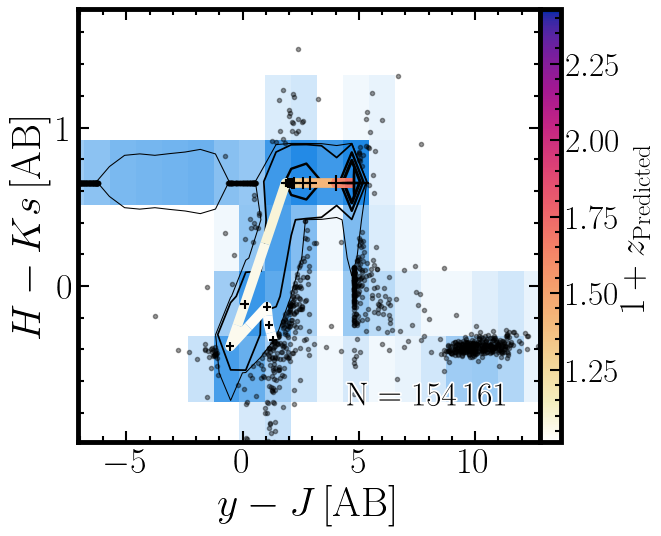

In [41]:
fig                = plt.figure(figsize=(6.5, 5.25), layout='constrained')
ax1                = fig.add_subplot(111, xscale='linear', yscale='linear')

try:
    norm_dens = mcolors.LogNorm()
except:
    pass

column_x         = 'y_K'
column_y         = 'H_K'
column_z         = 'pred_Z_rSFG'  # 'pred_Z_rSFG', 'Z'

xlabel           = r'$y - J\, [\mathrm{AB}]$'
ylabel           = r'$H - Ks\, [\mathrm{AB}]$'
mask_valid_vals  = np.isfinite(data_catalog_HETDEX_df.loc[:, column_x]) &\
                   np.isfinite(data_catalog_HETDEX_df.loc[:, column_y])
filter_good_cols  = mask_valid_vals & mask_pred_rSFG

dens_plot_data_x = data_catalog_HETDEX_df.loc[filter_good_cols, column_x]
dens_plot_data_y = data_catalog_HETDEX_df.loc[filter_good_cols, column_y]
dens_plot_data_z = 1 + data_catalog_HETDEX_df.loc[filter_good_cols, column_z]
N_sources        = np.nansum(filter_good_cols)

min_X  = np.nanmin(dens_plot_data_x)
max_X  = np.nanmax(dens_plot_data_x)
min_Y  = np.nanmin(dens_plot_data_y)
max_Y  = np.nanmax(dens_plot_data_y)

min_X_plot  = np.nanmin(sigma_clip(dens_plot_data_x, sigma=5, masked=False))
max_X_plot  = np.nanmax(sigma_clip(dens_plot_data_x, sigma=5, masked=False))
min_Y_plot  = np.nanmin(sigma_clip(dens_plot_data_y, sigma=5, masked=False))
max_Y_plot  = np.nanmax(sigma_clip(dens_plot_data_y, sigma=5, masked=False))
# max_X  = np.nanmax(1 + 1.99)  # Ad-hoc limit
# max_Y  = np.nanmax(1 + 1.99)  # Ad-hoc limit
n_bins = [25, 25]
bins_X_cont = np.linspace(min_X, max_X, int(np.floor(n_bins[0] * 1.7)))
bins_Y_cont = np.linspace(min_Y, max_Y, int(np.floor(n_bins[1] * 1.7)))
bins_X_hist = np.linspace(min_X, max_X, n_bins[0])
bins_Y_hist = np.linspace(min_Y, max_Y, n_bins[1])
bins_arr_cont = [bins_X_cont, bins_Y_cont]
bins_arr_hist = [bins_X_hist, bins_Y_hist]

dens_CW = gf.color_hist2d_scipy(dens_plot_data_x,
                                dens_plot_data_y,
                                dens_plot_data_z,
                                ax_tmp=ax1,
                                target_statistic='count',
                                bins=bins_arr_hist,
                                cmap=cm_grad_SFG_whi,
                                lw=0,
                                norm=norm_dens)

added_lim_up    = 0.0  # 0.049
added_lim_do    = 0.99  # 9.9e-1
# lims_x          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
# lims_y          = (added_lim_do, np.max([max_X, max_Y]) + added_lim_up)
lims_x          = (added_lim_do, max_X)
lims_y          = (added_lim_do, max_Y)

# sigmas_perc     = [0.39346934, 0.86466472, 0.988891]  # [0.39346934, 0.86466472, 0.988891, 0.99966454, 0.99999627]
sigmas_perc     = [0.5, 0.75, 0.95, 0.99]  # [50%, 75%, 95% of data]
outlier_number  = int(np.floor(N_sources * (1 - sigmas_perc[-1]))) # expected number of points outside last contour
nstep           = len(sigmas_perc)
seq_cont        = np.linspace(0, 1, nstep)

H_SFG, xedges_SFG, yedges_SFG = np.histogram2d(dens_plot_data_x, dens_plot_data_y,
                                               bins=bins_arr_cont, density=False)

# cont_SFG = ax1.scatter([-1], [10], marker='o', edgecolor=colour_rSFG, color=colour_black,
#                        s=80, label='$\mathrm{Predicted ~ rAGN}$', linewidths=2.5)

# Flatten histogram and sort by density
H_flat   = H_SFG.ravel()
H_sorted = np.sort(H_flat)[::-1]  # Sort descending
cumulative_density = np.cumsum(H_sorted) / np.sum(H_sorted)

# Find bin count thresholds for the desired percentiles
target_percentiles = np.array(sigmas_perc) * np.sum(H_SFG)
density_thresholds = []
for target in target_percentiles:
    idx = np.argmin(np.abs(cumulative_density * np.sum(H_SFG) - target))
    threshold = H_sorted[idx]
    density_thresholds.append(threshold)
density_thresholds = sorted(set(density_thresholds), reverse=True)  # Ensure unique, decreasing values

# fix probable lines not closing
H_SFG, x_centers_SFG, y_centers_SFG = gf.pad_matrix_zeros(H_SFG, xedges_SFG, yedges_SFG)

# Plot contours using the computed density thresholds
CS_SFG = ax1.contour(x_centers_SFG, y_centers_SFG, H_SFG.T,  
                     levels=density_thresholds[::-1],  
                     colors=cm_gradient_black.reversed()(seq_cont),  
                     linewidths=np.linspace(0.75, 2.25, len(sigmas_perc)), zorder=3)

# Calculate percentage levels from density thresholds
# density_percentages = [100.0 * cumulative_density[np.searchsorted(np.sort(H_flat), level)] for level in density_thresholds]
density_percentages = [100 * sigma_perc for sigma_perc in sigmas_perc]

# Identify and plot points outside contours
try:
    p_SFG = CS_SFG.get_paths()
except Exception as e:
    p_SFG = CS_SFG.collections[0].get_paths()
inside_SFG = np.full_like(dens_plot_data_x, False, dtype=bool)
for level in p_SFG:
    inside_SFG |= level.contains_points(np.column_stack((dens_plot_data_x, dens_plot_data_y)))
print(f'There are {np.sum(inside_SFG)} sources inside contours')
print(f'There are {np.sum(~inside_SFG)} sources outside contours')
print(f'It is expected to have {outlier_number} sources outside contours')
out_SFG, = ax1.plot(dens_plot_data_x.loc[~inside_SFG], dens_plot_data_y.loc[~inside_SFG],
                    marker='.', ls='None', color=colour_black, zorder=2, alpha=0.4)

num_str = f'$\mathrm{{N}} = {N_sources}$'
if N_sources / 1e4 > 1:
    num_str = f'$\mathrm{{N}} = {N_sources:,.0f}$'.replace(',', '$\,$')
ax1.annotate(num_str, xy=(0.93, 0.07), xycoords='axes fraction',
                    fontsize=24, path_effects=gf.path_white(2.5),
                    va='bottom', ha='right')

norm_z  = mcolors.Normalize()
# lines = colored_line(med_x, med_y, med_z, ax1, linewidth=5, cmap='cet_glasbey_hv', zorder=3)
med_x, med_y, med_z = create_median_values(dens_plot_data_x,
                                           dens_plot_data_y,
                                           dens_plot_data_z,
                                           nbins=25, scale='inverselog')
lines = colored_line(med_x, med_y, med_z,
                     ax1, linewidth=7, cmap='cet_CET_L17', zorder=3, norm=norm_z)
# ax1.plot(med_x, med_y, marker='+', ls='None', color='k', ms=10, zorder=4)
ax1.scatter(med_x, med_y, marker='+', ls='None', color='k', s=(np.array(med_z)**2 * 10)**1.5, zorder=4)

# ax1.set_xlim(lims_x)
# ax1.set_ylim(lims_y)

# ax1.set_xlim(left=-0.2, right=5.0)
# ax1.set_ylim(bottom=-0.6, top=1.1)
ax1.set_xlim(left=min_X_plot, right=max_X_plot)
ax1.set_ylim(bottom=min_Y_plot, top=max_Y_plot)

# cbar_str = r'$\mathrm{Sources ~ per ~ bin}$'
# cbar = fig.colorbar(dens_CW[1], ax=ax1, pad=0.0, format=ScalarFormatter())
# cbar.ax.minorticks_on()
# cbar.ax.tick_params(labelsize=24)
# cbar.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
# cbar.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
# cbar.outline.set_linewidth(3.5)
# cbar.ax.set_ylabel(cbar_str, size=26, labelpad=-1)

cbar_z_str = r'$1 + z_{\mathrm{Predicted}}$'
cbar_z = fig.colorbar(lines, ax=ax1, pad=0.0, format=ScalarFormatter())
cbar_z.ax.minorticks_on()
cbar_z.ax.tick_params(labelsize=24)
cbar_z.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
cbar_z.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
cbar_z.outline.set_linewidth(3.5)
cbar_z.ax.set_ylabel(cbar_z_str, size=26, labelpad=-1)

ax1.minorticks_on()
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=26)
# ax1.tick_params(axis='both', which='minor', labelsize=26)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(xlabel, size=30)
ax1.set_ylabel(ylabel, size=30)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)

if save_plots:
    plt.savefig(gv.plots_path + f'z_evol_H_Ks_y_J_rSFG_{used_sample}_HETDEX.pdf',
                bbox_inches='tight')

plt.show()

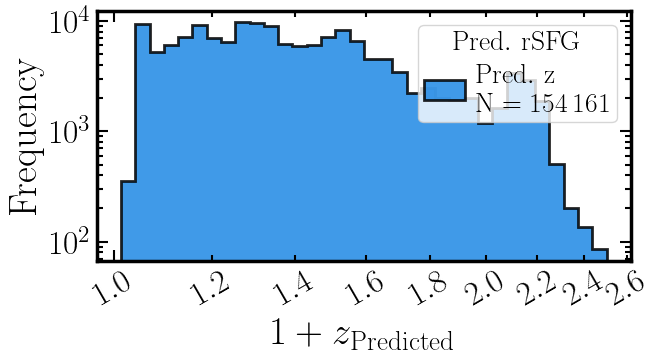

In [54]:
fig = plt.figure(figsize=(6.5, 3.5), layout='constrained')
ax1 = fig.add_subplot(111, xscale='log', yscale='log')

column_z_pred = 'pred_Z_rSFG'
column_z_true = 'Z'
xlabel   = r'$1 + z_{\mathrm{Predicted}}$'
ylabel   = r'$\mathrm{Frequency}$'

size_p_rSFG       = np.sum(mask_pred_rSFG)
num_str_p_rSFG    = r'$\mathrm{Pred. ~ z}$' + '\n' +  f'$\mathrm{{N}} = {size_p_rSFG}$'
if size_p_rSFG / 1e4 >= 1:
    num_str_p_rSFG = r'$\mathrm{Pred. ~ z}$' + '\n' +  f'$\mathrm{{N}} = {size_p_rSFG:,.0f}$'.replace(',', '$\,$')

if used_sample != 'unknown':
    size_t_rSFG       = np.sum(mask_true_rSFG)
    num_str_t_rSFG    = r'$\mathrm{True ~ z}$' + '\n' +  f'$\mathrm{{N}} = {size_t_rSFG}$'
    if size_t_rSFG / 1e4 >= 1:
        num_str_t_rSFG = r'$\mathrm{True ~ z}$' + '\n' +  f'$\mathrm{{N}} = {size_t_rSFG:,.0f}$'.replace(',', '$\,$')
    data_z_true = 1 + data_catalog_HETDEX_df.loc[mask_pred_rSFG, column_z_true]

data_z_pred = 1 + data_catalog_HETDEX_df.loc[mask_pred_rSFG, column_z_pred]

min_Z  = np.nanmin(data_z_pred)
max_Z  = np.nanmax(data_z_pred)
if used_sample != 'unknown':
    min_Z  = np.nanmin([np.nanmin(data_z_pred), np.nanmin(data_z_true)])
    max_Z  = np.nanmax([np.nanmax(data_z_pred), np.nanmax(data_z_true)])

z_bins = np.logspace(np.log10(min_Z), np.log10(max_Z), 35)    

ax1.hist(data_z_pred, bins=z_bins, histtype='stepfilled', edgecolor='k', linewidth=2.0,
         color=colour_hex_SFG, alpha=0.85, label=num_str_p_rSFG)

# ax1.annotate(num_str_p_rSFG, xy=(0.93, 0.93), xycoords='axes fraction',
#                     fontsize=22, path_effects=gf.path_white(2.5),
#                     va='top', ha='right')

if used_sample != 'unknown':
    ax1.hist(data_z_true, bins=z_bins, histtype='step', edgecolor='k', linewidth=2.0,
         color=colour_hex_SFG, alpha=0.85, label=num_str_t_rSFG, hatch='///')
    # ax1.annotate(num_str_t_rSFG, xy=(0.93, 0.55), xycoords='axes fraction',
    #                 fontsize=22, path_effects=gf.path_white(2.5),
    #                 va='top', ha='right')

ax1.minorticks_on()
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=24)
ax1.tick_params(axis='both', which='minor', labelsize=24)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel(xlabel, size=28)
ax1.set_ylabel(ylabel, size=28)
plt.setp(ax1.spines.values(), linewidth=2.5)
plt.setp(ax1.spines.values(), linewidth=2.5)

# ax1.yaxis.set_major_formatter(ticker.LogFormatterSciNotation())
# ax1.set_ylim(top=9990)

ax1.legend(title=r'$\mathrm{Pred. ~ rSFG}$', fontsize=20, title_fontsize=20,
           loc=1, borderpad=0.2, labelspacing=0.3, handlelength=1.5,
           handletextpad=0.4)

ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))
# ax1.xaxis.set_major_formatter(ScalarFormatter()) 
ax1.xaxis.set_minor_formatter(ScalarFormatter())
ax1.tick_params(axis='x', which='both', labelrotation=30)

if save_plots:
    plt.savefig(gv.plots_path + f'z_histograms_rSFG_{used_sample}_HETDEX.pdf',
                bbox_inches='tight')
plt.show()

There are 151936 sources inside contours
There are 2225 sources outside contours
It is expected to have 1541 sources outside contours


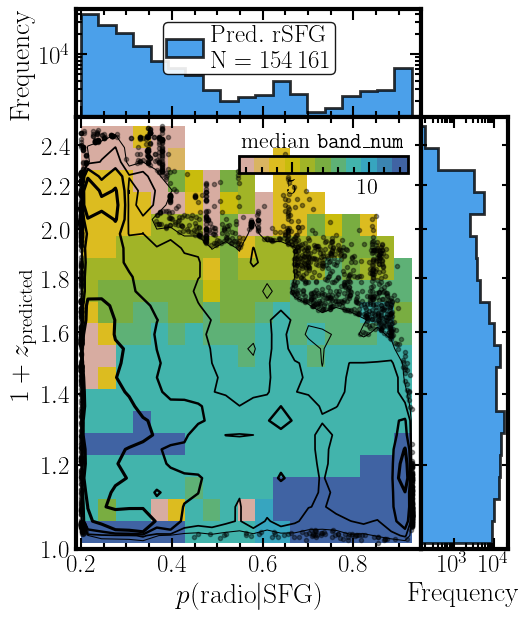

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=2,
                         width_ratios=[4, 1],
                         height_ratios=[1, 4],
                         figsize=(5, 6),
                         layout='compressed',
                         sharex='col', sharey='row',
                         gridspec_kw={'wspace': 0, 'hspace': 0})
axes_flat = axes.flatten()

axes_flat[0].set_yscale('log')
axes_flat[2].set_yscale('log')
axes_flat[3].set_xscale('log')

x_col = 'Prob_radio_SFG'
y_col = 'pred_Z_rSFG'
z_col = 'band_num'

plot_outliers = True

mask_valid_vals   = np.isfinite(data_catalog_HETDEX_df.loc[:, column_x]) &\
                    np.isfinite(data_catalog_HETDEX_df.loc[:, column_y])
filter_pred_Z_SFG = mask_valid_vals & mask_pred_rSFG

x_data_SFG = data_catalog_HETDEX_df.loc[filter_pred_Z_SFG, x_col]
y_data_SFG = 1 + data_catalog_HETDEX_df.loc[filter_pred_Z_SFG, y_col]
z_data_SFG = data_catalog_HETDEX_df.loc[filter_pred_Z_SFG, z_col].astype('int32')

x_data     = x_data_SFG
y_data     = y_data_SFG
z_data     = z_data_SFG

min_z  = np.nanmin(y_data)
max_z  = np.nanmax(y_data)
z_bins = np.logspace(np.log10(min_z), np.log10(max_z), 20)

min_prob  = np.nanmin(x_data)
max_prob  = np.nanmax(x_data)
prob_bins = np.linspace(min_prob, max_prob, 20)

size_p_rSFG       = np.sum(filter_pred_Z_SFG)
num_str_p_rSFG      = '$\mathrm{Pred. ~ rSFG}$' + '\n' +  f'$\mathrm{{N}} = {size_p_rSFG}$'
if size_p_rSFG / 1e4 >= 1:
    num_str_p_rSFG = '$\mathrm{Pred. ~ rSFG}$' + '\n' +  f'$\mathrm{{N}} = {size_p_rSFG:,.0f}$'.replace(',', '$\,$')
axes_flat[0].hist(x_data, bins=prob_bins, histtype='stepfilled', color='#1E88E5', alpha=0.8,
                  edgecolor='k', linewidth=2.0, label=num_str_p_rSFG)
axes_flat[0].legend(loc='upper center', fontsize=18, ncol=2, borderpad=0.1,
                    handlelength=1.5, handletextpad=0.3, columnspacing=0.2,
                    framealpha=0.9, edgecolor='k')

axes_flat[3].hist(y_data, bins=z_bins, histtype='stepfilled', color='#1E88E5', alpha=0.8,
                  orientation='horizontal', edgecolor='k', linewidth=2.0, label=num_str_p_rSFG)

contour_colour   = colour_black
cmap_hist2d      = cmap_hist2d_cats_SFG
colour_gradient  = cm_gradient_black

n_bins_cont      = [30, 25]

lims_x                = (gv.cal_radio_gals_thresh - 0.01, 0.95)
lims_y                = (1.0, max_z + 0.05)

sigmas_perc           = [0.5, 0.75, 0.95, 0.99]  # [50%, 75%, 95% of data]

clb_position          = [0.47, 0.87, 0.49, 0.04]

axes_flat[1].set_axis_off()

N_sources   = np.shape(x_data)[0]
norm_dens   = mcolors.Normalize(vmin=1.5, vmax=12.5)
# bins_Y_hist = np.logspace(np.log10(min_z), np.log10(max_z), n_bins_hist[0])
# bins_X_hist = np.linspace(min_prob, max_prob, n_bins_hist[1])
bins_Y_cont = np.logspace(np.log10(min_z), np.log10(max_z), n_bins_cont[0])
bins_X_cont = np.linspace(min_prob, max_prob, n_bins_cont[1])

# bins_hist   = [bins_X_hist, bins_Y_hist]
bins_cont   = [bins_X_cont, bins_Y_cont]

dens_CW     = gf.color_hist2d_scipy(x_data,
                                    y_data,
                                    z_data,
                                    ax_tmp=axes_flat[2],
                                    target_statistic='median',
                                    bins=[prob_bins, z_bins],
                                    cmap=cmap_hist2d,
                                    lw=0,
                                    norm=norm_dens)

cax = axes_flat[2].inset_axes(clb_position)
cbar = fig.colorbar(dens_CW[1], cax=cax, orientation='horizontal')
cbar.ax.minorticks_on()
cbar.ax.tick_params(labelsize=16)
cbar.ax.tick_params(which='major', length=8, width=1.5, direction='in', color='k')
cbar.ax.tick_params(which='minor', length=4, width=1.5, direction='in', color='k')
cbar.outline.set_linewidth(2.0)
# cbar.ax.set_xlabel(r'$\mathrm{Sources ~ per ~ bin}$', size=16, labelpad=-3)
# cbar.ax.set_title(r'$\mathrm{Sources ~ per ~ bin}$', size=16)
cbar.ax.set_title(r'$\mathrm{median}~\mathtt{band\_num}$', size=16)

outlier_number  = int(np.floor(N_sources * (1 - sigmas_perc[-1]))) # expected number of points outside last contour
nstep           = len(sigmas_perc)
seq_cont        = np.linspace(0, 1, nstep)

H_Sources, xedges_Sources, yedges_Sources = np.histogram2d(x_data, y_data,
                                               bins=bins_cont, density=False)

# Flatten histogram and sort by density
H_flat   = H_Sources.ravel()
H_sorted = np.sort(H_flat)[::-1]  # Sort descending
cumulative_density = np.cumsum(H_sorted) / np.sum(H_sorted)

# Find bin count thresholds for the desired percentiles
target_percentiles = np.array(sigmas_perc) * np.sum(H_Sources)
density_thresholds = []
for target in target_percentiles:
    idx = np.argmin(np.abs(cumulative_density * np.sum(H_Sources) - target))
    threshold = H_sorted[idx]
    density_thresholds.append(threshold)
density_thresholds = sorted(set(density_thresholds), reverse=True)  # Ensure unique, decreasing values

# fix probable lines not closing
H_Sources, x_centers_Sources, y_centers_Sources = gf.pad_matrix_zeros(H_Sources, xedges_Sources, yedges_Sources)

# Plot contours using the computed density thresholds
CS_Sources = axes_flat[2].contour(x_centers_Sources, y_centers_Sources, H_Sources.T,  
                     levels=density_thresholds[::-1],  
                     colors=cm_gradient_black.reversed()(seq_cont),  
                     linewidths=np.linspace(0.75, 2.25, len(sigmas_perc)),
                                  zorder=3)  # linewidths=2.25
if plot_outliers:
    try:
        p_Sources = CS_Sources.get_paths()
    except Exception as e:
        p_Sources = CS_Sources.collections[0].get_paths()
    inside_Sources = np.full_like(x_data, False, dtype=bool)
    for level in p_Sources:
        inside_Sources |= level.contains_points(np.column_stack((x_data, y_data)))
    print(f'There are {np.sum(inside_Sources)} sources inside contours')
    print(f'There are {np.sum(~inside_Sources)} sources outside contours')
    print(f'It is expected to have {outlier_number} sources outside contours')
    out_Sources, = axes_flat[2].plot(x_data.loc[~inside_Sources], y_data.loc[~inside_Sources],
                        marker='.', ls='None', color=colour_black, zorder=2, alpha=0.4)
    
axes_flat[0].set_xlim(*lims_x)
axes_flat[2].set_ylim(*lims_y)

axes_flat[0].set_ylabel(r'$\mathrm{Frequency}$', fontsize=20)
axes_flat[2].set_xlabel(r'$p(\mathrm{radio} | \mathrm{SFG})$', fontsize=20)
axes_flat[2].set_ylabel(r'$1 + z_{\mathrm{predicted}}$', fontsize=20)
axes_flat[3].set_xlabel(r'$\mathrm{Frequency}$', fontsize=20)

for count, ax_tmp in enumerate(axes_flat):
    if count == 1: continue
    if count == 2:
        ax_tmp.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%0.1f$'))
        ax_tmp.yaxis.set_minor_formatter(ScalarFormatter())
        ax_tmp.tick_params(axis='y', which='minor', labelsize=18)
    if count % 2 == 1:
        ax_tmp.yaxis.set_major_formatter(ScalarFormatter())
        ax_tmp.ticklabel_format(axis='y', style='plain')

    ax_tmp.minorticks_on()
    ax_tmp.tick_params(which='both', top=True, right=True, direction='in')
    ax_tmp.tick_params(axis='both', which='major', labelsize=18)
    ax_tmp.tick_params(axis='x', which='minor', labelsize=18)
    ax_tmp.tick_params(which='major', length=8, width=1.5)
    ax_tmp.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_tmp.spines.values(), linewidth=3)
    plt.setp(ax_tmp.spines.values(), linewidth=3)

axes_flat[0].yaxis.set_major_locator(ticker.LogLocator(base=10.0, numticks=5))
# for label in axes_flat[0].get_yticklabels():
#     label.set_ha('right')  # Align to the right
#     label.set_va('bottom')  # Vertically center-align

fig.get_layout_engine().set(w_pad=0 / 72, h_pad=0 / 72, hspace=0, wspace=0)
if save_plots:
    plt.savefig(gv.plots_path + f'pred_z_vs_radio_prob_hists_rSFG_{used_sample}_HETDEX.pdf',
                bbox_inches='tight')
plt.show()